In [1]:
import geopandas as gpd
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from pandasql import sqldf
import xml.etree.ElementTree as et 
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits import mplot3d
import seaborn as sns
Minimum_Sample_Size = 0
pd.options.mode.chained_assignment = None

In [6]:
def load_posts():
    xtree = et.parse("./data/datascience_stackexchange_com/Posts.xml")
    xroot = xtree.getroot() 
    df_cols = ["Id","PostTypeId", "ParentID","AcceptedAnswerId","CreationDate","Score","ViewCount","OwnerUserId","Tags"]
    rows = []
    for x in xroot:
        row = dict()
        for col in df_cols:
            if col in x.attrib:
                row[col] = x.attrib[col]
            else:
                row[col] = None
        rows.append(row)
    user_df = pd.DataFrame(rows, columns = df_cols)
    return user_df

In [7]:
data_posts = load_posts()
print(data_posts.shape)
data_posts.head()

(39929, 9)


,Id,PostTypeId,ParentID,AcceptedAnswerId,CreationDate,Score,ViewCount,OwnerUserId,Tags
0,5,1,None,None,2014-05-13T23:58:30.457,8,604,5,<machine-learning>
1,7,1,None,10,2014-05-14T00:11:06.457,4,426,36,<education><open-source>
2,9,2,None,None,2014-05-14T00:36:31.077,5,None,51,None
3,10,2,None,None,2014-05-14T00:53:43.273,12,None,22,None
4,14,1,None,29,2014-05-14T01:25:59.677,23,1495,66,<data-mining><definitions>


In [8]:
data_posts.isnull().any()

Id                  False
PostTypeId          False
ParentID             True
AcceptedAnswerId     True
CreationDate        False
Score               False
ViewCount            True
OwnerUserId          True
Tags                 True
dtype: bool

In [9]:
data_posts['Tags'].isnull().sum()

21416

In [10]:
tag_rows = []
cols = ["Id","Tag"]
for index, row in data_posts.iterrows():
    pid = row['Id']
    tag = row['Tags']
    if tag is not None:
        tags = re.split('><|>|<',tag) 
        for t in tags:
            if len(t.strip())>0:
                tag_rows.append({"Id":pid,"Tag":t})
    else:
        tag_rows.append({"Id":pid,"Tag":None})
data_tags = pd.DataFrame(tag_rows, columns = cols)

In [11]:
data_tags.head()

,Id,Tag
0,5,machine-learning
1,7,education
2,7,open-source
3,9,None
4,10,None


In [12]:
data_posts_part = data_posts[['Id','PostTypeId','CreationDate','Score','ViewCount','AcceptedAnswerId','ParentID','OwnerUserId']]
data_posts_part['CreationDate'] = pd.to_datetime(data_posts_part['CreationDate'], format="%Y-%m-%d %H:%M:%S")
data_posts_part['YearCreated'] = data_posts_part.CreationDate.dt.year
data_posts_part.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,AcceptedAnswerId,ParentID,OwnerUserId,YearCreated
0,5,1,2014-05-13 23:58:30.457,8,604,None,None,5,2014
1,7,1,2014-05-14 00:11:06.457,4,426,10,None,36,2014
2,9,2,2014-05-14 00:36:31.077,5,None,None,None,51,2014
3,10,2,2014-05-14 00:53:43.273,12,None,None,None,22,2014
4,14,1,2014-05-14 01:25:59.677,23,1495,29,None,66,2014


In [14]:
data_posts_temp = pd.merge(data_posts_part, data_tags, on='Id',  how='right')
print(data_posts_temp.shape)
data_posts_temp.head()

(75368, 10)


,Id,PostTypeId,CreationDate,Score,ViewCount,AcceptedAnswerId,ParentID,OwnerUserId,YearCreated,Tag
0,5,1,2014-05-13 23:58:30.457,8,604,None,None,5,2014,machine-learning
1,7,1,2014-05-14 00:11:06.457,4,426,10,None,36,2014,education
2,7,1,2014-05-14 00:11:06.457,4,426,10,None,36,2014,open-source
3,9,2,2014-05-14 00:36:31.077,5,None,None,None,51,2014,None
4,10,2,2014-05-14 00:53:43.273,12,None,None,None,22,2014,None


In [15]:
data_posts_temp_gp = data_posts_temp.groupby(['Tag','YearCreated']).size().reset_index()
data_posts_temp_gp.columns=['Tag','YearCreated','Pop']

In [16]:
data_posts_temp_gp['Tag'].nunique()

489

In [17]:
rep = data_posts_temp_gp.groupby('Tag')['YearCreated'].agg(['count']).reset_index()
print(rep.shape)
rep.head()

(489, 2)


,Tag,count
0,.net,5
1,3d-reconstruction,1
2,ab-test,6
3,accuracy,6
4,activation,1


In [18]:
data_posts_temp_gp = pd.merge(data_posts_temp_gp, rep, on='Tag',  how='left')
data_posts_temp_gp.head()

,Tag,YearCreated,Pop,count
0,.net,2014,1,5
1,.net,2015,1,5
2,.net,2016,1,5
3,.net,2017,2,5
4,.net,2019,1,5


In [19]:
data_posts_temp_gp = data_posts_temp_gp[data_posts_temp_gp['count']>2]
data_posts_temp_gp.head()

,Tag,YearCreated,Pop,count
0,.net,2014,1,5
1,.net,2015,1,5
2,.net,2016,1,5
3,.net,2017,2,5
4,.net,2019,1,5


In [20]:
data_posts_temp_gp_14 = data_posts_temp_gp[data_posts_temp_gp.YearCreated==2014]
#data_posts_temp_gp_14 = data_posts_temp_gp_14.sort_values(by='Pop', ascending=False)
data_posts_temp_gp_14 = data_posts_temp_gp_14[data_posts_temp_gp_14['Pop']>Minimum_Sample_Size]
print(data_posts_temp_gp_14.shape)
data_posts_temp_gp_14.head()

(142, 4)


,Tag,YearCreated,Pop,count
0,.net,2014,1,5
6,ab-test,2014,2,6
12,accuracy,2014,9,6
42,algorithms,2014,27,6
64,anomaly-detection,2014,2,6


In [21]:
data_posts_temp_gp_15 = data_posts_temp_gp[data_posts_temp_gp.YearCreated==2015]
#data_posts_temp_gp_15 = data_posts_temp_gp_15.sort_values(by='Pop', ascending=False)
data_posts_temp_gp_15 = data_posts_temp_gp_15[data_posts_temp_gp_15['Pop']>Minimum_Sample_Size]
print(data_posts_temp_gp_15.shape)
data_posts_temp_gp_15.head()

(211, 4)


,Tag,YearCreated,Pop,count
1,.net,2015,1,5
7,ab-test,2015,1,6
13,accuracy,2015,3,6
23,active-learning,2015,1,4
32,aggregation,2015,1,5


In [22]:
data_posts_temp_gp_16 = data_posts_temp_gp[data_posts_temp_gp.YearCreated==2016]
#data_posts_temp_gp_16 = data_posts_temp_gp_16.sort_values(by='Pop', ascending=False)
data_posts_temp_gp_16 = data_posts_temp_gp_16[data_posts_temp_gp_16['Pop']>Minimum_Sample_Size]
print(data_posts_temp_gp_16.shape)
data_posts_temp_gp_16.head()

(259, 4)


,Tag,YearCreated,Pop,count
2,.net,2016,1,5
8,ab-test,2016,11,6
14,accuracy,2016,14,6
19,activation-function,2016,2,4
33,aggregation,2016,2,5


In [23]:
data_posts_temp_gp_17 = data_posts_temp_gp[data_posts_temp_gp.YearCreated==2017]
#data_posts_temp_gp_17 = data_posts_temp_gp_17.sort_values(by='Pop', ascending=False)
data_posts_temp_gp_17 = data_posts_temp_gp_17[data_posts_temp_gp_17['Pop']>Minimum_Sample_Size]
print(data_posts_temp_gp_17.shape)
data_posts_temp_gp_17.head()

(314, 4)


,Tag,YearCreated,Pop,count
3,.net,2017,2,5
9,ab-test,2017,7,6
15,accuracy,2017,17,6
20,activation-function,2017,9,4
24,active-learning,2017,1,4


In [24]:
data_posts_temp_gp_18 = data_posts_temp_gp[data_posts_temp_gp.YearCreated==2018]
#data_posts_temp_gp_18 = data_posts_temp_gp_16.sort_values(by='Pop', ascending=False)
data_posts_temp_gp_18 = data_posts_temp_gp_18[data_posts_temp_gp_18['Pop']>Minimum_Sample_Size]
print(data_posts_temp_gp_18.shape)
data_posts_temp_gp_18.head()

(322, 4)


,Tag,YearCreated,Pop,count
10,ab-test,2018,2,6
16,accuracy,2018,49,6
21,activation-function,2018,25,4
25,active-learning,2018,2,4
30,actor-critic,2018,4,3


In [25]:
data_posts_temp_gp_19 = data_posts_temp_gp[data_posts_temp_gp.YearCreated==2019]
#data_posts_temp_gp_19 = data_posts_temp_gp_19.sort_values(by='Pop', ascending=False)
data_posts_temp_gp_19 = data_posts_temp_gp_19[data_posts_temp_gp_19['Pop']>Minimum_Sample_Size]
print(data_posts_temp_gp_19.shape)
data_posts_temp_gp_19.head()

(325, 4)


,Tag,YearCreated,Pop,count
4,.net,2019,1,5
11,ab-test,2019,3,6
17,accuracy,2019,60,6
22,activation-function,2019,32,4
26,active-learning,2019,4,4


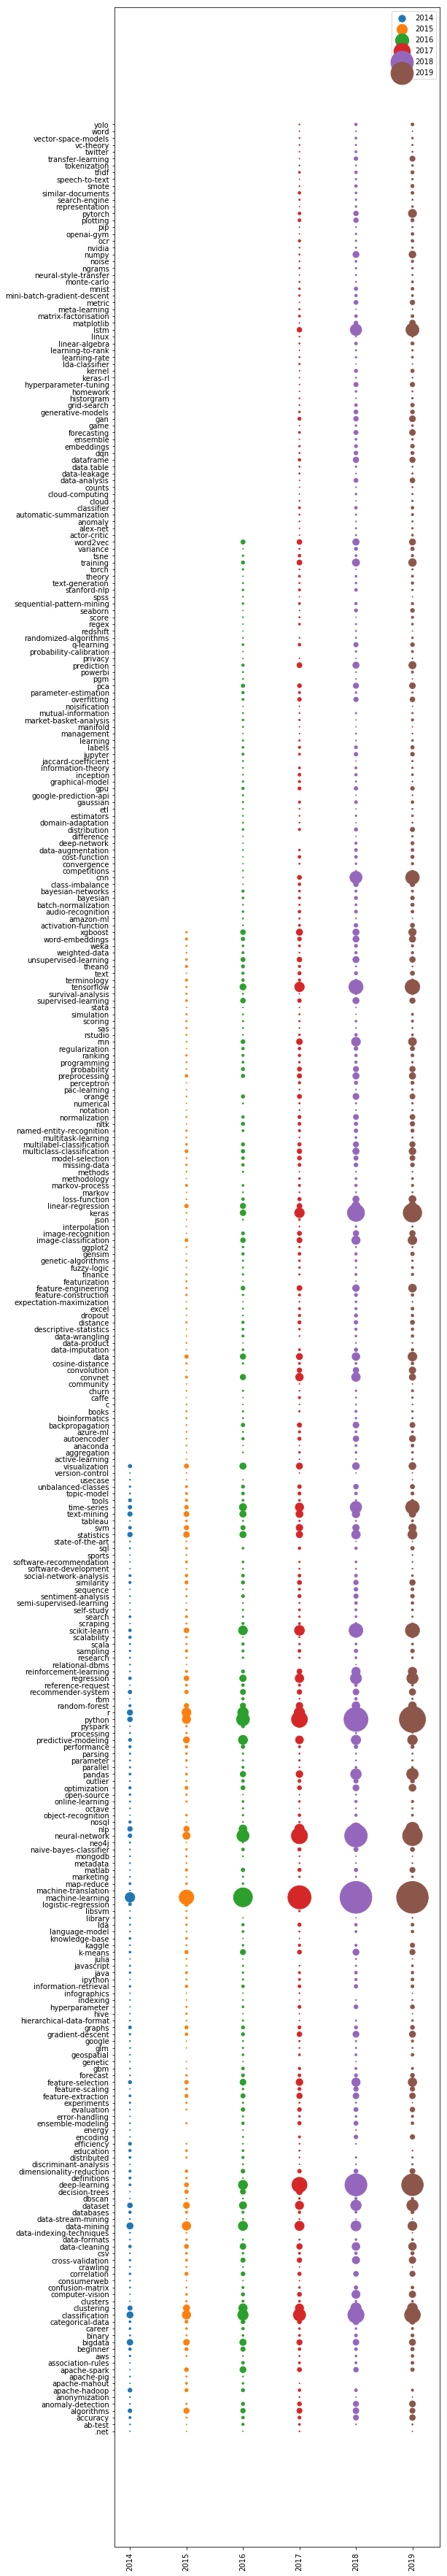

In [26]:
%matplotlib inline
plt.subplots(figsize = (8,64))
plt.scatter(data_posts_temp_gp_14.YearCreated,data_posts_temp_gp_14.Tag,  s=data_posts_temp_gp_14.Pop,  label='2014')
plt.scatter(data_posts_temp_gp_15.YearCreated,data_posts_temp_gp_15.Tag,  s=data_posts_temp_gp_15.Pop,  label='2015')
plt.scatter(data_posts_temp_gp_16.YearCreated,data_posts_temp_gp_16.Tag,  s=data_posts_temp_gp_16.Pop,  label='2016')
plt.scatter(data_posts_temp_gp_17.YearCreated,data_posts_temp_gp_17.Tag,  s=data_posts_temp_gp_17.Pop,  label='2017')
plt.scatter(data_posts_temp_gp_18.YearCreated,data_posts_temp_gp_18.Tag,  s=data_posts_temp_gp_18.Pop,  label='2018')
plt.scatter(data_posts_temp_gp_19.YearCreated,data_posts_temp_gp_19.Tag,  s=data_posts_temp_gp_19.Pop,  label='2019')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [27]:
interest = ['classification','deep-learning','machine-learning','neural-network','python','time-series','keras','tensorflow','cnn','matplotlib']
data_posts_temp_int = data_posts_temp_gp[data_posts_temp_gp['Tag'].isin(interest)]

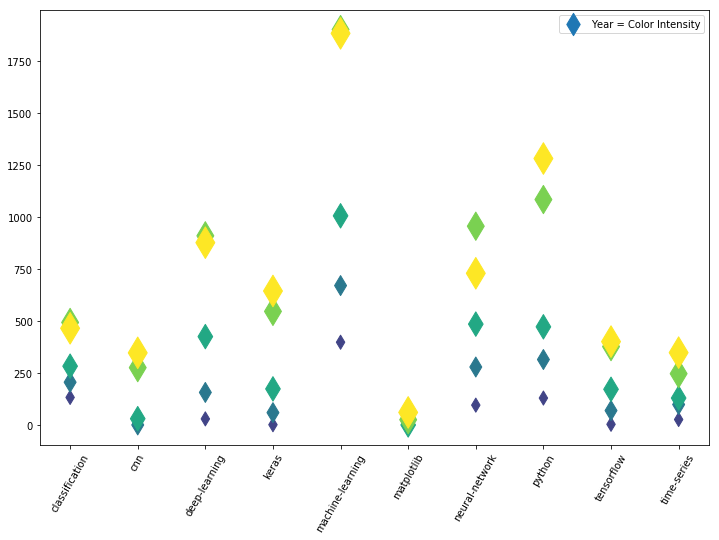

In [28]:
plt.subplots(figsize = (12,8))
plt.scatter(data_posts_temp_int.Tag,data_posts_temp_int.Pop, c=data_posts_temp_int.YearCreated, marker='d', s=(data_posts_temp_int.YearCreated%2014*100), label='Year = Color Intensity')
plt.xticks(rotation=60)
plt.legend()
plt.show()